<link rel="stylesheet" href="https://fonts.googleapis.com/css?family=Sofia">
<style>
  @import url('https://fonts.googleapis.com/css2?family=Concert+One&display=swap');
  .topic {
    text-align: center;
    font-weight: 900;
    font-size: 50px;
    text-shadow: 3px 3px 3px #ababab;
    font-family: 'Concert One', sans-serif;
  }
  @import url('https://fonts.googleapis.com/css2?family=Lobster&display=swap');
  .info {
    text-align: center;
    font-weight: 800;
    font-size: 40px;
    font-family: 'Lobster', sans-serif;
  }
</style>

<h1 class=topic>Google Analytics Customer Revenue Prediction</h1>
<h2 class=info>Vũ Minh Phát - 21127739</h2>

___

## Import

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
import json

## Exploring your data

**Read cleaned data from file**

In [4]:
cleaned_df = pd.read_csv("../data/processed/train_preprocessed.csv")

In [5]:
cleaned_df.head()

,channelGrouping,date,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,...,totals.newVisits,totals.transactionRevenue,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,date.day,date.year,date.month,date.weekDay,date.weekOfYear
0,Organic Search,2016-09-02,1,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,...,True,0.0,google,organic,False,2,2016,9,4,35
1,Organic Search,2016-09-02,1,Firefox,Macintosh,False,desktop,Oceania,Australasia,Australia,...,True,0.0,google,organic,False,2,2016,9,4,35
2,Organic Search,2016-09-02,1,Chrome,Windows,False,desktop,Europe,Southern Europe,Spain,...,True,0.0,google,organic,False,2,2016,9,4,35
3,Organic Search,2016-09-02,1,UC Browser,Linux,False,desktop,Asia,Southeast Asia,Indonesia,...,True,0.0,google,organic,False,2,2016,9,4,35
4,Organic Search,2016-09-02,2,Chrome,Android,True,mobile,Europe,Northern Europe,United Kingdom,...,False,0.0,google,organic,True,2,2016,9,4,35


In [6]:
cleaned_df.columns

Index(['channelGrouping', 'date', 'visitNumber', 'device.browser',
       'device.operatingSystem', 'device.isMobile', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.city', 'totals.hits',
       'totals.pageviews', 'totals.bounces', 'totals.newVisits',
       'totals.transactionRevenue', 'trafficSource.source',
       'trafficSource.medium', 'trafficSource.isTrueDirect', 'date.day',
       'date.year', 'date.month', 'date.weekDay', 'date.weekOfYear'],
      dtype='object')

## Đặt câu hỏi

**Câu hỏi 1**: Tỉ lệ chi tiêu của mỗi quốc gia so với tổng quốc gia và tỉ lệ số lần mua của từng quốc gia so với tổng quốc gia như thế nào?

**Lợi ích**: Trả lời câu hỏi trên sẽ giúp ta đánh giá được các quốc gia có lượng chi tiêu lớn cũng như các quốc gia có số lượng mua nhiều, qua đó giúp có chiến lược quảng cáo tốt hơn, tập trung vào các khu vực có số lượng mua lớn cũng như tăng số lượng mua của khu vực đó lên.

**Thực hiện**: Với mỗi quốc gia tính:

s1 = số tiền quốc gia chi / số tiền toàn thế giới chi

s2 = số lần truy cập của quốc gia / số lần truy cập toàn thế giới

s3 = số lần mua hàng của quốc gia / số lần mua hàng của thế giới


tỉ lệ 1 = s1/s2

tỉ lệ 2 = s3/s2

Sau đó ta vẽ hai geochart thể hiện 2 tỉ lệ trên cho từng quốc gia, và vẽ 2 bar chart cho top 5 quốc gia cho từng tỉ lệ. 

In [50]:
label = 'geoNetwork.country'

l = cleaned_df[label].copy()
unis = l.unique()
data = cleaned_df['totals.transactionRevenue'].copy()

values = []

for uni in unis:
    s1 = sum(data[l == uni]) / sum(data)
    s2 = sum(l == uni) / len(l)
    s3 = sum((l == uni) & (data > 0)) / sum(data > 0)
    t1 = s1 / s2
    t2 = s3 / s2
    values.append((uni, t1, t2))

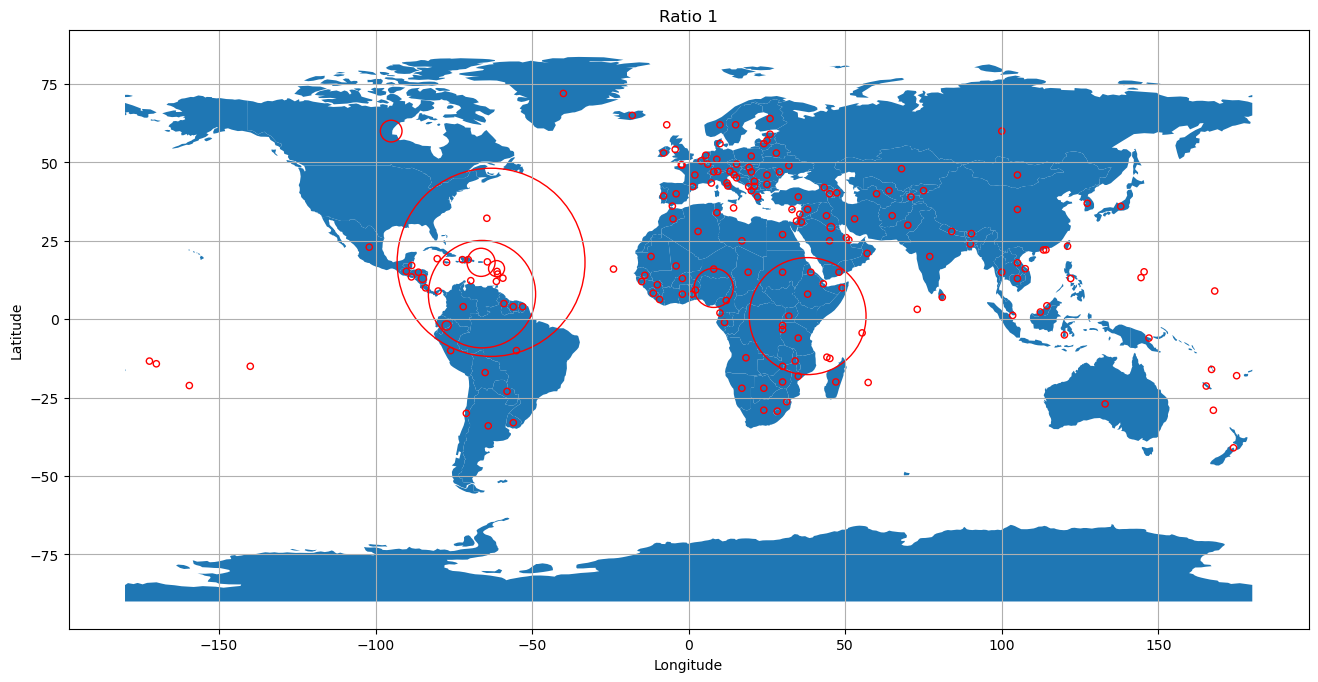

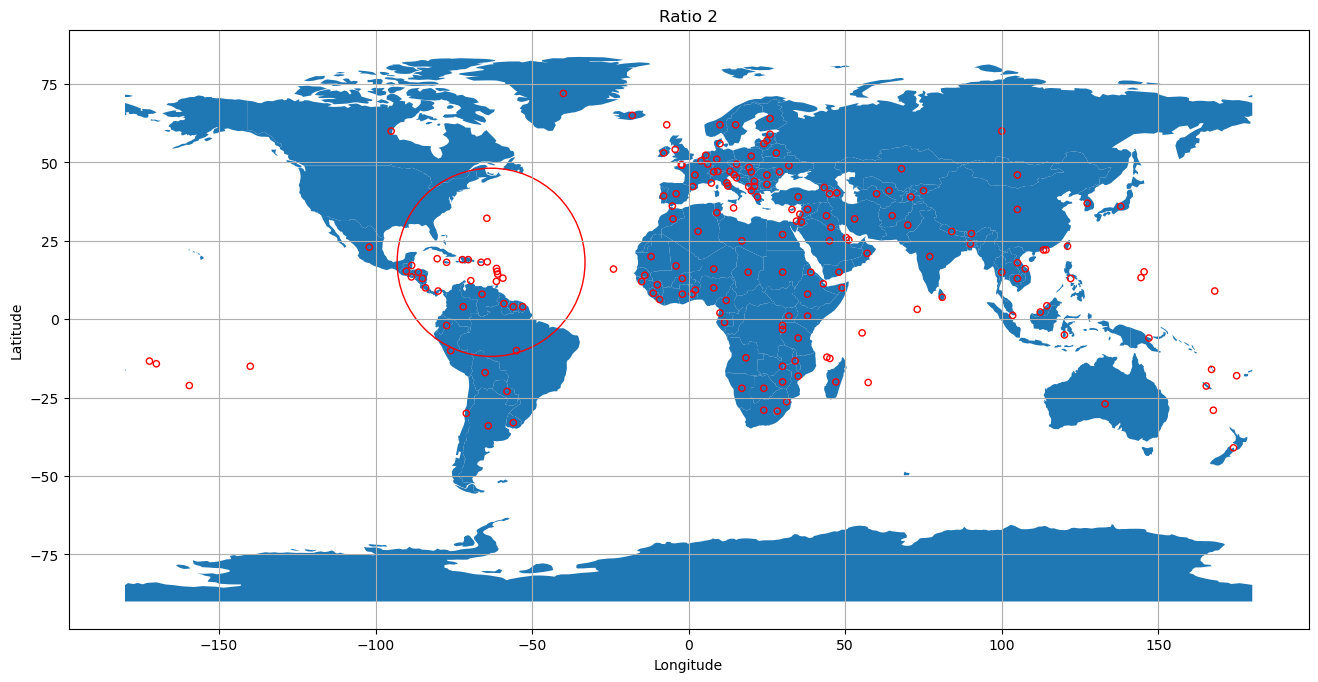

In [56]:
money_df = pd.DataFrame(values)
money_df.columns = ['Country', 'Ratio 1', 'Ratio 2']

with open('../data/coord.json') as file:
    coordinates = json.load(file)

coord_data = {
    'Country': list(coordinates['lat'].keys()),
    'Latitude': list(coordinates['lat'].values()),
    'Longitude': list(coordinates['long'].values())
}

coord_df = pd.DataFrame(coord_data)
merged_df = pd.merge(money_df, coord_df, on='Country')

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


# Ratio 1
m_ratio_1 = np.max(merged_df['Ratio 1'])
fig, ax = plt.subplots(figsize=(16, 12))
world.plot(ax=ax)
for ind in merged_df.index:
    circle = plt.Circle((merged_df['Longitude'][ind], merged_df['Latitude'][ind]), max(merged_df['Ratio 1'][ind] / m_ratio_1 * 30, 1), color='red', fill=False)
    ax.add_patch(circle)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Ratio 1')
plt.grid(True)
plt.show()
# Ratio 2
m_ratio_2 = np.max(merged_df['Ratio 2'])
fig, ax = plt.subplots(figsize=(16, 12))
world.plot(ax=ax)
for ind in merged_df.index:
    circle = plt.Circle((merged_df['Longitude'][ind], merged_df['Latitude'][ind]), max(merged_df['Ratio 2'][ind] / m_ratio_2 * 30, 1), color='red', fill=False)
    ax.add_patch(circle)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Ratio 2')
plt.grid(True)
plt.show()

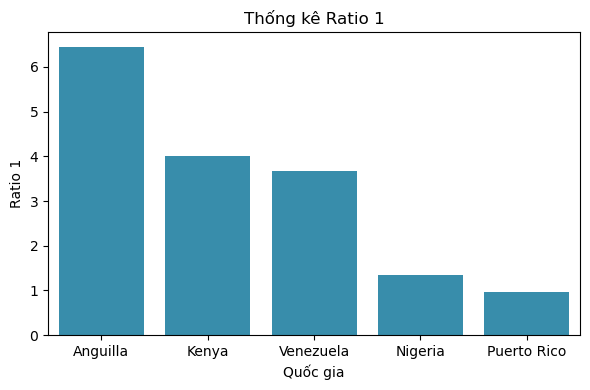

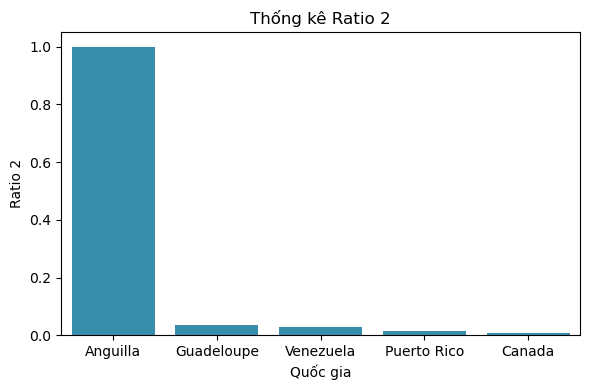

In [63]:
fields = ['Ratio 1', 'Ratio 2']

# Create subplots for each field
for field in fields:
    # Sort values for the current field in descending order
    sorted_df = merged_df.sort_values(by=field, ascending=False).head(5)

    # Create bar plot using Seaborn
    plt.figure(figsize=(6, 4))
    sns.barplot(x='Country', y=field, data=sorted_df, color='#2596be')
    plt.title(f'Thống kê {field}')
    plt.xlabel('Quốc gia')
    plt.ylabel(field)
    plt.tight_layout()
    plt.show()

**Nhận xét**: Ta thấy được rằng chỉ có một số ít quốc gia có tỉ lệ chi tiêu lớn và chỉ có một quốc gia có tỉ lệ lần mua nhiều. Anguilla là quốc gia có cả 2 tỉ lệ ở mức lớn hơn rất nhiều so với toàn thế giới. Ngoài ra một số quốc gia như: Kenya, Venezuela, Nigeria, Puerto Rico có tỉ lệ chi tiêu rất lớn so với tỉ lệ số lần mua.

**Câu hỏi 2**: Có mối quan hệ nào giữa số tiền chi tiêu so với các giá trị khác trong phiên giao dịch hay không?

Trả lời câu hỏi trên sẽ giúp chúng ta đánh giá được sự ảnh yếu tố trong phiên giao dịch trước khi khách hàng đưa ra quyết định thanh toán cuối cùng, qua đó có được quyết định tiếp thị tốt hơn trong phiên giao dịch.

In [7]:
total = cleaned_df[['totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits', 'totals.transactionRevenue']].copy()
corr_matrix = total.corr()
corr_matrix['totals.transactionRevenue'].sort_values(ascending=False)

totals.transactionRevenue    1.000000
totals.pageviews             0.155590
totals.hits                  0.154333
totals.bounces              -0.032206
totals.newVisits            -0.041164
Name: totals.transactionRevenue, dtype: float64

**Câu 3**: Tỉ lệ giữa số tiền chi tiêu so với số lần chi tiêu là bao nhiêu.

Trả lời câu hỏi sẽ giúp chúng ta đánh giá được tình hình mua hàng, liêu người mua sẽ chi một số lượng tiền lớn cho một lần mua hay sẽ mua theo nhiều lần với số tiền thấp.

In [8]:
data = cleaned_df['totals.transactionRevenue'].copy()
times_ratio = sum(data > 0) / len(data)
spend_ratio = data[data > 0].median() / sum(data)
print(f'>> Tỉ lệ số lần thanh toán là : {times_ratio * 100: .3f}%')
print(f'>> Tỉ lệ số tiền chi tiêu là: {spend_ratio * 100: .3f}%')
print(f'>> Tỉ lệ số lần thanh toán so với số tiền chi là: {times_ratio/spend_ratio: .3f}')

>> Tỉ lệ số lần thanh toán là :  1.274%
>> Tỉ lệ số tiền chi tiêu là:  0.003%
>> Tỉ lệ số lần thanh toán so với số tiền chi là:  396.859


<Axes: ylabel='Frequency'>

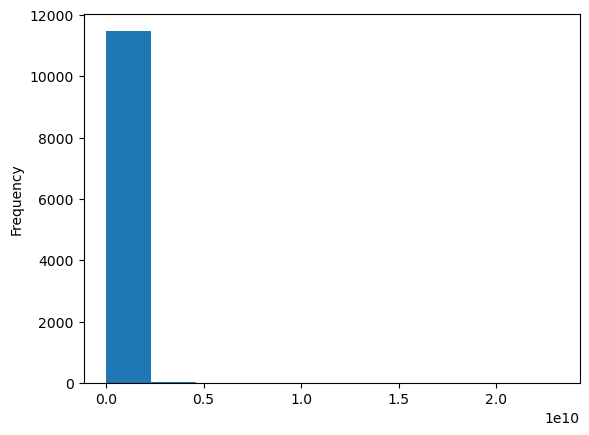

In [9]:
data[data > 0].plot.hist()

<Axes: ylabel='Frequency'>

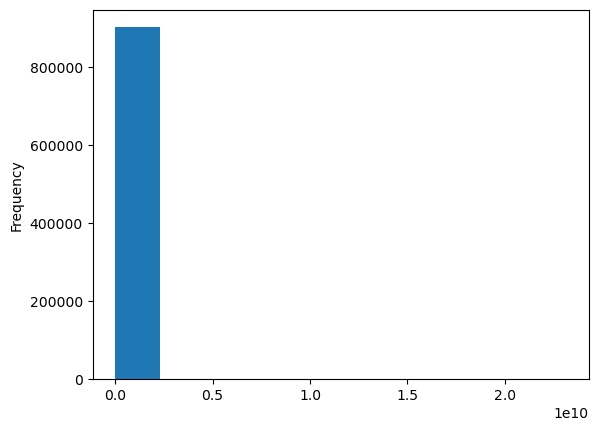

In [10]:
data.plot.hist()